## Search Algorithms

Below is an implementation of Chapter 3's concepts.

### Notes
Chapter 3 considers the simplest possible environments: episodic, single agent, fully observable, deterministic, static, discrete, and known

Recall these facts about the above terms:
* **Episodic (counterpart: sequential)** - each action is taken without considering the previous actions
* **Single Agent (counterpart: multi-agent)** - only one agent simplifies the problem because the agent need not consider the actions of other agents when deciding on its own.
* **Fully observable (counterparts: partially observable or unobservable)** - the agent is fully aware of its environment. In other words, at each step in its search it can query all the information about the state space.
* **Deterministic (counterpart: stochastic)** - The transition model is not probabilistic. In other words, taking an action at a given state with always result in the same new state.
* **Static (counterpart: dynamic)** - When the agent is thinking about which action to take, the environment and time are effectively frozen.
* **Discrete (counterpart: continuous)** - The number of possible values for attributes of the state space are countable.

### Problem
A problem has the following:
* `states`: A set of possible states, called the state space
* `initial_state`: An initial state
* `goal_states`: One or more goal states
* `actions()`: A method that returns a set of actions that are available at a given state
* `result()`: The "transition model which describes what each action does". It takes in the current state and an action to take at that state and returns the resulting state.
* `action_cost()`: Returns the cost of transitioning from a source state to a destination state by taking a given action.  

In other programming languages I would have defined this as an interface or abstract class, but that seemed complicated in python, so I opted to just provide the fields and functions as dependencies to a Problem's constructor.

In [6]:
from collections.abc import Callable


class State:
    def __init__(self, name: str):
        self.name = name


class Action:
    def __init__(self, name: str):
        self.name = name


class Problem:
    states: set[State] = None
    initial_state: State = None
    goal_states: set[State] = None

    type ActionsFunction = Callable[[State], set[Action]]
    actions: ActionsFunction = None

    type ResultFunction = Callable[[State, Action], State]
    result: ResultFunction = None

    type ActionCostFunction = Callable[[State, Action, State], float]
    action_cost: ActionCostFunction = None

    def __init__(
        self,
        states: set[State],
        initial_state: State,
        goal_states: set[State],
        actions: ActionsFunction,
        result: ResultFunction,
        action_cost: ActionCostFunction,
    ):
        self.states = states
        self.initial_state = initial_state
        self.goal_states = goal_states
        self.actions = actions
        self.result = result
        self.action_cost = action_cost

    def is_goal(self, state: State):
        return state in self.goal_states

    def __str__(self):
        return (
            f"states={[state.name for state in self.states]}\n"
            + f"initial_state={self.initial_state.name}\n"
            + f"goal_states={[state.name for state in self.goal_states]}"
        )

### Search Node
A `SearchNode` is a self-referential data structure similar to a linked list node that keeps track of the traversal of the problem space. Each instance records:
* `state`: The state that was arrived at by taking the associated action
* `parent`: The parent `SearchNode` that represents the traversals of the state space up to the point before choosing this state. This is the self-referential part.
* `action`: The action taken to get to the current state.
* `path_cost`: The total cost of the traversals up to and including this node.

In [7]:
from typing import Self


class SearchNode:
    def __init__(
        self, state: State, parent: Self, action: Action, path_cost: float = 0
    ):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = parent.depth + 1 if parent else 0

    def __str__(self):
        seen = set()
        trav = self
        output = ""
        while trav is not None:
            if trav in seen:
                output = "[Cycle detected!] ->" + output
                break
            # Verbose: output = f"(s={trav.state.name},a={trav.action.name if trav.action else "none"},c={trav.path_cost}) ->" + output
            # Simple:
            output = f"{trav.state.name}" + output
            if trav.parent:
                output = " -> " + output
            trav = trav.parent
        return output

    def __lt__(self, other: Self):
        return self.path_cost < other.path_cost

### Example Problem
Arad to Bucharest
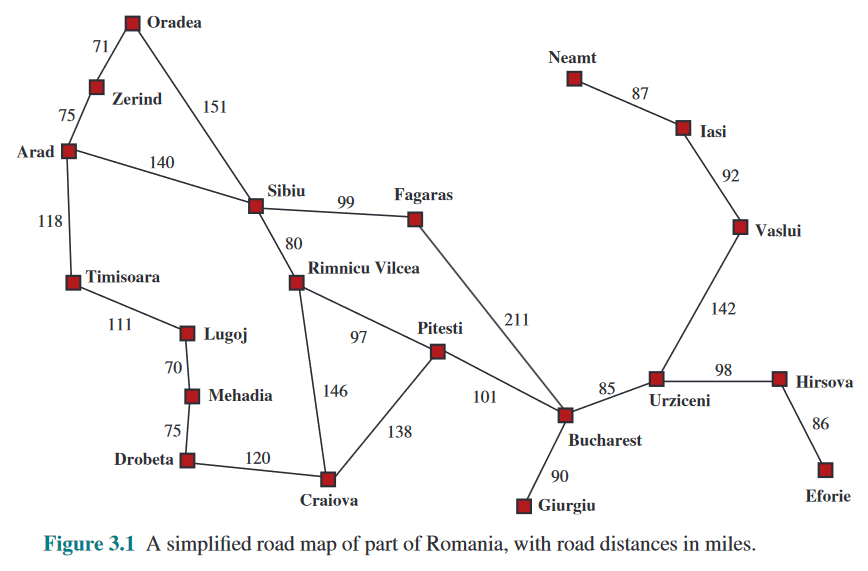
This problem is featured in the book and shown as the above figure. 

This figure depicts the state space as a graph, where each node represents a city in Romania and each edge represents the path from one city to another. The weight of an edge represents the distance between the cities. 

The problem is encoded below as a python dictionary, and parsed by the `createRomaniaProblem()` function. It parses and assembles the string based data into the concrete types and functions defined above in accordance with the `Problem` interface.

The output uses the `__str__` operator overload function of the `Problem` class to print the states, initial state, and goal states of the problem.

In [8]:
romania_data = {
    "initial_state": "Arad",
    "goal_states": ["Bucharest"],
    "states": [
        "Oradea",
        "Zerind",
        "Arad",
        "Timisoara",
        "Sibiu",
        "Lugoj",
        "Mehadia",
        "Drobeta",
        "Craiova",
        "Rimnicu Vilcea",
        "Fagaras",
        "Pitesti",
        "Bucharest",
        "Giurgiu",
        "Urziceni",
        "Hirsova",
        "Eforie",
        "Vaslui",
        "Iasi",
        "Neamt",
    ],
    "directed": False,
    "edges": [
        ("Oradea", "Zerind", 71),
        ("Oradea", "Sibiu", 151),
        ("Zerind", "Arad", 75),
        ("Arad", "Sibiu", 140),
        ("Arad", "Timisoara", 118),
        ("Timisoara", "Lugoj", 111),
        ("Lugoj", "Mehadia", 70),
        ("Mehadia", "Drobeta", 75),
        ("Drobeta", "Craiova", 120),
        ("Craiova", "Rimnicu Vilcea", 146),
        ("Craiova", "Pitesti", 138),
        ("Sibiu", "Fagaras", 99),
        ("Sibiu", "Rimnicu Vilcea", 80),
        ("Fagaras", "Bucharest", 211),
        ("Rimnicu Vilcea", "Pitesti", 97),
        ("Pitesti", "Bucharest", 101),
        ("Bucharest", "Giurgiu", 90),
        ("Bucharest", "Urziceni", 85),
        ("Urziceni", "Hirsova", 98),
        ("Hirsova", "Eforie", 86),
        ("Urziceni", "Vaslui", 142),
        ("Vaslui", "Iasi", 92),
        ("Iasi", "Neamt", 87),
    ],
}


def createRomaniaProblem(data) -> Problem:
    # Maps the string representation of the state to a State object
    state_map: dict[str, State] = dict(
        [(state, State(state)) for state in data["states"]]
    )

    # Maps a (source, destination) pair to a cost.
    edges: dict[(State, State), int] = dict()
    for source, destination, cost in data["edges"]:
        source = state_map[source]
        destination = state_map[destination]
        edges[(source, destination)] = cost
        # If the data is not directed, store the opposite direction
        if not data["directed"]:
            edges[(destination, source)] = cost
    initial_state = state_map[data["initial_state"]]
    goal_states = [state_map[state_name] for state_name in data["goal_states"]]

    # Map of State to Actions. Actions for this problem are the same as States
    state_to_action: dict[State, Action] = dict(
        [(state, Action(state.name)) for state in state_map.values()]
    )

    # Valid actions that can be taken at each statez
    actions_for_state: dict[State, set[Action]] = dict()
    for state in state_map.values():
        actions_for_state[state] = set()
    for source, destination in edges:
        new_action = state_to_action[destination]
        actions_for_state[source].add(new_action)

    def actions(state: State) -> set[Action]:
        return actions_for_state[state]

    def result(state: State, action: Action) -> State:
        if action.name not in state_map:
            return None
        return state_map[action.name]

    def action_cost(state: State, action: Action, new_state: State) -> float:
        if (state, new_state) not in edges:
            return None
        return edges[(state, new_state)]

    return Problem(
        set(state_map.values()),
        initial_state,
        goal_states,
        actions,
        result,
        action_cost,
    )


romania_problem = createRomaniaProblem(romania_data)
print(romania_problem)

states=['Giurgiu', 'Rimnicu Vilcea', 'Urziceni', 'Sibiu', 'Craiova', 'Vaslui', 'Iasi', 'Oradea', 'Pitesti', 'Mehadia', 'Hirsova', 'Bucharest', 'Arad', 'Drobeta', 'Neamt', 'Zerind', 'Eforie', 'Lugoj', 'Fagaras', 'Timisoara']
initial_state=Arad
goal_states=['Bucharest']


### Search Algorithms

Measures of algorithm performance:
* **Completeness**: Is the algorithm guaranteed to find a solution when there is one, and to correctly report failure when there is not?
* **Cost optimality**: Does it find a solution with the lowest path cost of all solutions?
* **Time complexity**: How long does it take to find a solution? This can be measured in seconds, or more abstractly by the number of states and actions considered.
* **Space complexity**: How much memory is needed to perform the search?

The proceeding subheadings show different search algorithm implementations, but first, let's define a benchmarking function that might help us get an understanding of how fast these algorithms are compared to eachother.

In [9]:
import time


# Benchmarks a given function and prints the average time in two ways
# The precision of process_time is low, so it may produce inaccurate
# results for calls that last less than the lower bound.
def benchmark(f: Callable, n: int = 10000):
    print(f"Benchmark (n={n}):")
    start = time.perf_counter_ns()
    start_process = time.process_time_ns()
    for i in range(n):
        f()
    end = time.perf_counter_ns()
    end_process = time.process_time_ns()
    perf_counter_avg = (end - start) / n / 1e3
    process_time_avg = (end_process - start_process) / n / 1e3
    print(f"perf_counter avg: {perf_counter_avg:.2f}ms")
    print(f"process_time avg: {process_time_avg:.2f}ms")

#### Best-first search

In [10]:
from queue import PriorityQueue


# Returns a SearchNode representing a linked path from destination to source
# f is the ordering function for the priority queue which backs the frontier
def best_first_search(
    problem: Problem, f: Callable[[SearchNode], float]
) -> SearchNode | None:
    node = SearchNode(problem.initial_state, None, None, 0)
    frontier = PriorityQueue()
    frontier.put((f(node), node))
    reached: dict[State, SearchNode] = {node.state: node}
    while frontier.not_empty:
        _, node = frontier.get()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            state = child.state
            if state not in reached or child.path_cost < reached[state].path_cost:
                reached[state] = child
                frontier.put((f(node), child))
    return None


# Given a node, returns the nodes representing the actions you can take from that node
def expand(problem: Problem, node: SearchNode) -> list[SearchNode]:
    state = node.state
    expanded_nodes = []
    for action in problem.actions(state):
        next_state = problem.result(state, action)
        cost = node.path_cost + problem.action_cost(state, action, next_state)
        expanded_nodes.append(SearchNode(next_state, node, action, cost))
    return expanded_nodes

In [11]:
solution_node = best_first_search(romania_problem, lambda node: node.path_cost)
print(f"Shortest path (cost={solution_node.path_cost}): {solution_node}")

print()

benchmark(lambda: best_first_search(romania_problem, lambda node: node.path_cost))

Shortest path (cost=450): Arad -> Sibiu -> Fagaras -> Bucharest

Benchmark (n=10000):
perf_counter avg: 35.07ms
process_time avg: 10.94ms


#### Breadth-first Search (BFS)

BFS is useful when all actions have the same cost. The root node is expanded first. Each expansion the connected nodes are added to the end of the frontier. That way nodes are processed and expanded as they are found, in order of how far they are from the root.

* BFS is **Cost-optimal** for problems where actions have the same cost, because the cost is defined as the depth, and nodes are processed by depth, so the lowest cost path will be found by natural exploration pattern of the algorithm.
* BFS is **Complete** in any case because it explores the state space systematically.
* **Time Complexity**: $O(b^d)$, where b is the branching factor and d is the depth of the solution
* **Space Complexity**: $O(b^d)$

BFS can be implemented as best-first search where the evaluation function $f(n)$ is the depth of the node, instead of the path cost:

In [12]:
# BFS is best-first search where the cost function is node depth
def best_bfs_test():
    return best_first_search(romania_problem, lambda node: node.depth)


solution_node = best_bfs_test()
print(f"Shortest path (cost={solution_node.path_cost}): {solution_node}")

benchmark(best_bfs_test)

Shortest path (cost=450): Arad -> Sibiu -> Fagaras -> Bucharest
Benchmark (n=10000):
perf_counter avg: 35.80ms
process_time avg: 14.06ms


Several changes can be made to the best-first search algorithm in the special case of BFS:
* We can implement BFS with a FIFO queue rather than the Priority Queue used in best-first search. 
    * This is a bit faster because you don't need to rebalance the heap for inserts, which is common in Priority Queues.
* For the reached structure we can use a set of states rather than a mapping from `State` to `SearchNode`.
    * This is because once we reach a state there is never a better path to that state.
* Because the cost is the same as the depth, and we process nodes by depth, if we encounter a goal state when expanding a node then we know that we have found the cost-optimal path. 
    * We don't need to wait until we pop it off the queue.


In [13]:
from queue import Queue


def breadth_first_search(problem: Problem):
    node = SearchNode(problem.initial_state, None, None)
    if problem.is_goal(node.state):
        return node
    frontier = Queue()
    frontier.put(node)
    reached: set[State] = set([problem.initial_state])
    while not frontier.empty():
        node = frontier.get()
        for child in expand(problem, node):
            state = child.state
            if problem.is_goal(state):
                return child
            if state not in reached:
                reached.add(state)
                frontier.put(child)
    return None

Here we test the BFS algorithm on the Romania problem, but note that because BFS doesn't use the cost of the nodes, it will only find the shortest path in terms of nodes to Bucharest. Therefore, it's a coincidence that the solution paths are the same.

In [14]:
def bfs_test():
    return breadth_first_search(romania_problem)


solution_node = bfs_test()
cost = solution_node.path_cost
depth = solution_node.depth
print(f"Shortest path (cost={cost}, depth={depth}): {solution_node}")

benchmark(bfs_test)

Shortest path (cost=450, depth=3): Arad -> Sibiu -> Fagaras -> Bucharest
Benchmark (n=10000):
perf_counter avg: 20.86ms
process_time avg: 10.94ms


#### Problem Generation
The only example problem we've used is the Romania problem. It's actions have costs. To more appropriately test BFS and other algorithms which don't consider action cost / assume actions cost the same, we should create more problems. 

I'll call these problems unit cost or unweighted. Unit cost meaning each action only costs 1, or unweighted as an unweighted graph doesn't have weights assigned to its edges.

Let's write some code that will generate unit cost problems for us to use:

In [127]:
from itertools import count
from dataclasses import dataclass
from random import random

@dataclass
class Graph:
    nodes: list[int]
    edges: list[tuple[int, int]]

def generate_graph(
    branch_factor: int = 3,
    max_depth: int = 4,
    prune_chance: float = 0.5,
    directed: bool = False,
) -> Graph:
    nodes: list[int] = []
    # Edges represented as a set of tuples where each is (source, destination)
    edges: list[tuple[int, int]] = set()
    # Holds nodes that need to be expanded where each is (node id, depth)
    q: Queue[tuple[int, int]] = Queue()
    # Counter to assign IDs to nodes
    node_id_counter = count(1)

    # place root node in queue
    root = next(node_id_counter)
    q.put((root, 0))
    nodes.append(root)

    # expand nodes in the queue until there are none left
    while not q.empty():
        parent, depth = q.get()
        for _ in range(branch_factor):
            # decide whether to prune this node's children
            if random() < prune_chance:
                continue

            child = next(node_id_counter)
            nodes.append(child)

            # create edges
            edges.add((parent, child))
            if not directed:
                edges.add((child, parent))

            # Insert this node into the queue to be expanded as
            # long as it's not at the max depth
            if depth + 1 < max_depth:
                q.put((child, depth + 1))

    return Graph(nodes, edges)

Now let's generate a random graph! Feel free to modify the values yourself.

In [128]:
graph = generate_graph(3, 6, 0.5, False)

##### Problem Visualization
It'd also be useful to visualize the problems we generate. We can use graphviz ([on pypi](https://pypi.org/project/graphviz/), [official page](https://graphviz.org/)) to create graph images from code. We'll inspect the Problem and generate an image of it.

If you don't already have graphviz installed on your computer, you might want to [follow these instructions](https://graphviz.readthedocs.io/en/stable/manual.html#user-guide). Pay close attention [if you're installing on Windows](https://forum.graphviz.org/t/new-simplified-installation-procedure-on-windows/224). It may require a restart of the application hosting this notebook, as it did for me.

In [16]:
# Install graphviz to produce problem visualizations
import sys
!{sys.executable} -m pip install graphviz

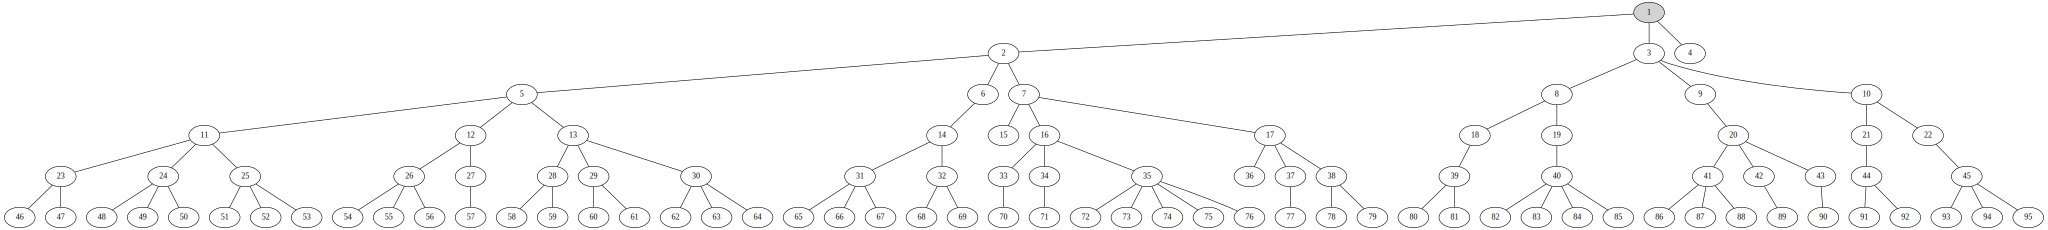

In [212]:
import graphviz

graph = generate_graph(5, 5, 0.6, False)
dot = graphviz.Graph(strict=True)
for node in graph.nodes:
    if node == 1:
        dot.node(str(node), style='filled', fillcolor='lightgrey')
    else:
        dot.node(str(node))
dot.edges([(str(a), str(b)) for a, b in sorted(graph.edges)])
dot